In [139]:
#instalando biblioteca do gradio
!pip install gradio

In [140]:
# Instalar a biblioteca torch
!pip install torch torchvision torchaudio

In [141]:
# Importando as bibliotecas necessárias
import torch  # Biblioteca principal para tensores e deep learning.
import torch.nn as nn  # Submódulo para criar e gerenciar camadas de redes neurais.
import torch.optim as optim  # Submódulo para otimização, como SGD ou Adam.
from torchvision import datasets, transforms, models  # Importa ferramentas para carregar datasets, aplicar transformações e carregar modelos pré-treinados.
from torch.utils.data import DataLoader  # Permite carregar datasets em lotes para o treinamento.
import matplotlib.pyplot as plt  # Biblioteca para criar gráficos e visualizações.
import numpy as np  # Biblioteca para manipulação numérica e arrays.
import gradio as gr  # Biblioteca para criar interfaces web para modelos de machine learning.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report  # Funções para exibir e calcular métricas de classificação.
import time  # Módulo para medir o tempo de execução de funções.


In [142]:
# Configurando o dispositivo (GPU se disponível)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Define se o treinamento será feito na GPU ou CPU, dependendo da disponibilidade.


In [143]:
# Transformações para os dados de treinamento e teste (incluindo Data Augmentation)
transform = transforms.Compose([  # Aplica transformações nos dados de entrada para aumentar a robustez do modelo.
    transforms.Resize((224, 224)),  # Redimensiona a imagem para 224x224 pixels.
    transforms.RandomHorizontalFlip(),  # Aleatoriamente inverte horizontalmente a imagem.
    transforms.RandomRotation(10),  # Rotaciona a imagem aleatoriamente até 10 graus.
    transforms.RandomCrop(224, padding=10),  # Recorta a imagem de forma aleatória com padding de 10 pixels.
    transforms.ToTensor(),  # Converte a imagem para um tensor.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normaliza a imagem com valores específicos.
])


In [144]:
# Transformações apenas para predição (sem Data Augmentation) - utilizado para o upload de imagem.
predict_transform = transforms.Compose([  # Usado para imagens de predição, sem transformação aleatória.
    transforms.Resize((224, 224)),  # Redimensiona a imagem para 224x224 pixels.
    transforms.ToTensor(),  # Converte a imagem para um tensor.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normaliza a imagem.
])


In [145]:
# Carregando os dados (substitua 'path_to_train' e 'path_to_test' pelos caminhos corretos no seu diretório do Windows)
train_dataset = datasets.ImageFolder('C:/Users/Gustavo/Downloads/the_wildfire_dataset_2n_version/train', transform=transform)  # Carrega o conjunto de treinamento da pasta especificada.
test_dataset = datasets.ImageFolder('C:/Users/Gustavo/Downloads/the_wildfire_dataset_2n_version/test', transform=transform)  # Carrega o conjunto de teste da pasta especificada.


In [146]:
# Ajustando o tamanho do lote (Batch Size)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Carrega os dados de treinamento em lotes de 64, embaralhando-os.
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # Carrega os dados de teste em lotes de 64, sem embaralhar.


In [147]:
# Definindo o modelo (usando ResNet18 pré-treinada)
model = models.resnet18(pretrained=True)  # Carrega a arquitetura ResNet18 com pesos pré-treinados.
num_ftrs = model.fc.in_features  # Obtém o número de características da camada final.


C:\Users\Gustavo\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Gustavo\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [148]:
# Adicionando Dropout na camada final e ajustando para 2 classes
model.fc = nn.Sequential(  # Redefine a última camada da ResNet para adicionar Dropout e ajustar para 2 classes.
    nn.Dropout(0.5),  # Dropout para evitar overfitting.
    nn.Linear(num_ftrs, 2)  # Camada totalmente conectada para classificação em 2 classes.
)
model = model.to(device)  # Envia o modelo para o dispositivo (GPU ou CPU).

In [149]:
# Definindo a função de perda com pesos para classes desbalanceadas e o otimizador
class_weights = torch.tensor([0.7, 0.3]).to(device)  # Define pesos para lidar com o desbalanceamento das classes (ajuste conforme os dados).
criterion = nn.CrossEntropyLoss(weight=class_weights)  # Função de perda ponderada para ajustar o aprendizado das classes desbalanceadas.
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Define o otimizador SGD com taxa de aprendizado de 0.001 e momentum de 0.9.


In [150]:
# Adicionando scheduler para reduzir a taxa de aprendizado
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)  # Scheduler para reduzir a taxa de aprendizado com base na perda.


C:\Users\Gustavo\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [151]:
# Função de treinamento com early stopping e timers
def train_model(model, criterion, optimizer, scheduler, num_epochs=100):  # Função para treinar o modelo.
    total_start_time = time.time()  # Inicia o timer para calcular o tempo total de treinamento.
    early_stopping_patience = 5  # Define a paciência para o early stopping.
    best_loss = float('inf')  # Inicializa a melhor perda como infinita.
    patience_counter = 0  # Contador para o early stopping.

    for epoch in range(num_epochs):  # Loop de treinamento para cada época.
        epoch_start_time = time.time()  # Inicia o timer para calcular o tempo de cada época.

        model.train()  # Coloca o modelo em modo de treinamento.
        running_loss = 0.0  # Inicializa a variável de perda acumulada.
        correct = 0  # Inicializa o contador de acertos.
        total = 0  # Inicializa o contador total de amostras.

        for inputs, labels in train_loader:  # Loop pelos lotes de dados.
            inputs, labels = inputs.to(device), labels.to(device)  # Move os dados para o dispositivo.
            optimizer.zero_grad()  # Zera os gradientes do otimizador.
            outputs = model(inputs)  # Passa os dados pelo modelo.
            loss = criterion(outputs, labels)  # Calcula a perda.
            loss.backward()  # Calcula os gradientes.
            optimizer.step()  # Atualiza os parâmetros do modelo.

            running_loss += loss.item() * inputs.size(0)  # Acumula a perda total.
            _, predicted = torch.max(outputs, 1)  # Obtém as predições do modelo.
            total += labels.size(0)  # Conta o total de amostras.
            correct += (predicted == labels).sum().item()  # Conta o número de acertos.

        epoch_loss = running_loss / len(train_loader.dataset)  # Calcula a perda média por época.
        epoch_accuracy = 100 * correct / total  # Calcula a acurácia por época.

        # Calculando o tempo da época
        epoch_time = time.time() - epoch_start_time  # Calcula o tempo da época.
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Time: {epoch_time:.2f} segundos')  # Imprime o resumo da época.

        scheduler.step(epoch_loss)  # Ajusta a taxa de aprendizado com base na perda da época.

        # Early Stopping
        if epoch_loss < best_loss:  # Verifica se a perda atual é melhor que a melhor perda anterior.
            best_loss = epoch_loss  # Atualiza a melhor perda.
            patience_counter = 0  # Reseta o contador de paciência.
        else:
            patience_counter += 1  # Incrementa o contador de paciência.
            if patience_counter >= early_stopping_patience:  # Se a paciência for excedida, ativa o early stopping.
                print("Early stopping triggered")  # Informa o early stopping.
                break

    # Calculando o tempo total
    total_time = time.time() - total_start_time  # Calcula o tempo total de treinamento.
    print(f"Tempo total de treinamento: {total_time:.2f} segundos")  # Imprime o tempo total de treinamento.


In [152]:
# Função de avaliação com métricas adicionais (precision, recall, f1-score)
def evaluate_model(model):  # Função para avaliar o modelo.
    model.eval()  # Coloca o modelo em modo de avaliação.
    correct = 0  # Inicializa o contador de acertos.
    total = 0  # Inicializa o contador total de amostras.
    all_labels = []  # Lista para armazenar os rótulos verdadeiros.
    all_preds = []  # Lista para armazenar as predições do modelo.

    with torch.no_grad():  # Desativa a computação de gradientes para a avaliação.
        for inputs, labels in test_loader:  # Loop pelos dados de teste.
            inputs, labels = inputs.to(device), labels.to(device)  # Move os dados para o dispositivo.
            outputs = model(inputs)  # Passa os dados pelo modelo.
            _, predicted = torch.max(outputs, 1)  # Obtém as predições.
            total += labels.size(0)  # Conta o total de amostras.
            correct += (predicted == labels).sum().item()  # Conta o número de acertos.
            all_labels.extend(labels.cpu().numpy())  # Armazena os rótulos verdadeiros.
            all_preds.extend(predicted.cpu().numpy())  # Armazena as predições.

    accuracy = 100 * correct / total  # Calcula a acurácia do modelo.
    print(f'Accuracy: {accuracy:.2f}%')  # Imprime a acurácia.

    # Matriz de confusão e relatório de métricas
    cm = confusion_matrix(all_labels, all_preds)  # Calcula a matriz de confusão.
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não é Fogo', 'Fogo'])  # Exibe a matriz de confusão.
    disp.plot(cmap=plt.cm.Blues)  # Plota a matriz de confusão com o cmap em tons de azul.
    plt.show()  # Mostra o gráfico.

    # Relatório de classificação
    print(classification_report(all_labels, all_preds, target_names=['Não é Fogo', 'Fogo']))  # Exibe o relatório de classificação com precisão, recall e f1-score.

    return accuracy  # Retorna a acurácia.


In [153]:
# Treinando o modelo
train_model(model, criterion, optimizer, scheduler, num_epochs=100)  # Chama a função para treinar o modelo com 100 épocas.


Epoch 1/100, Loss: 0.5418, Accuracy: 64.11%, Time: 497.22 segundos
Epoch 2/100, Loss: 0.3440, Accuracy: 79.93%, Time: 492.45 segundos
Epoch 3/100, Loss: 0.2712, Accuracy: 85.41%, Time: 497.17 segundos
Epoch 4/100, Loss: 0.1979, Accuracy: 90.00%, Time: 496.01 segundos
Epoch 5/100, Loss: 0.1892, Accuracy: 89.73%, Time: 492.32 segundos
Epoch 6/100, Loss: 0.1529, Accuracy: 93.22%, Time: 493.54 segundos
Epoch 7/100, Loss: 0.1309, Accuracy: 94.25%, Time: 488.25 segundos
Epoch 8/100, Loss: 0.1072, Accuracy: 94.66%, Time: 493.59 segundos
Epoch 9/100, Loss: 0.1030, Accuracy: 95.21%, Time: 492.99 segundos
Epoch 10/100, Loss: 0.0762, Accuracy: 96.51%, Time: 491.14 segundos
Epoch 11/100, Loss: 0.0690, Accuracy: 97.05%, Time: 490.69 segundos
Epoch 12/100, Loss: 0.0710, Accuracy: 97.40%, Time: 494.12 segundos
Epoch 13/100, Loss: 0.0653, Accuracy: 96.64%, Time: 493.11 segundos
Epoch 14/100, Loss: 0.0647, Accuracy: 97.19%, Time: 491.81 segundos
Epoch 15/100, Loss: 0.0528, Accuracy: 98.15%, Time: 501.7

C:\Users\Gustavo\anaconda3\Lib\site-packages\PIL\Image.py:3218: DecompressionBombWarning: Image size (96631920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\Gustavo\anaconda3\Lib\site-packages\PIL\Image.py:3218: DecompressionBombWarning: Image size (94487082 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\Gustavo\anaconda3\Lib\site-packages\PIL\Image.py:3218: DecompressionBombWarning: Image size (101859328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Accuracy: 92.86%


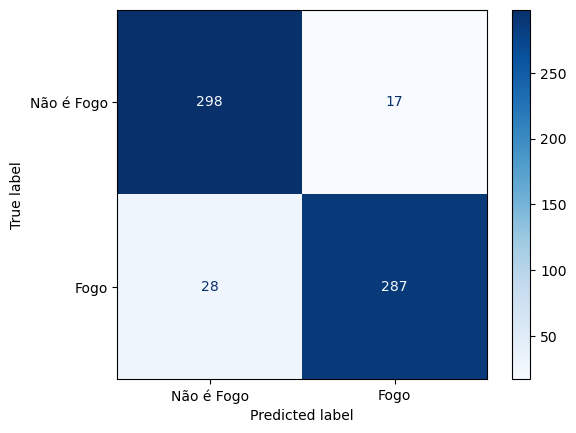

              precision    recall  f1-score   support

  Não é Fogo       0.91      0.95      0.93       315
        Fogo       0.94      0.91      0.93       315

    accuracy                           0.93       630
   macro avg       0.93      0.93      0.93       630
weighted avg       0.93      0.93      0.93       630



In [154]:
# Avaliando o modelo
accuracy = evaluate_model(model)  # Chama a função para avaliar o modelo e armazena a acurácia.


In [155]:
# Função para predição de uma imagem
def predict_image(img):  # Função para realizar predição em uma única imagem.
    img = predict_transform(img).unsqueeze(0).to(device)  # Aplica as transformações e adiciona uma dimensão extra ao tensor.
    model.eval()  # Coloca o modelo em modo de avaliação.
    with torch.no_grad():  # Desativa os gradientes.
        outputs = model(img)  # Passa a imagem pelo modelo.
        _, preds = torch.max(outputs, 1)  # Obtém a predição da classe.
    class_names = ['Fogo', 'Não é Fogo']  # Nomes das classes para a saída.
    return class_names[preds[0]]  # Retorna a classe predita.


In [156]:
# Interface Gradio
interface = gr.Interface(fn=predict_image, inputs=gr.Image(type="pil"), outputs="text", title="Classificação de Incêndios Florestais", description="Faça upload de uma imagem para verificar se há fogo ou não.")  # Cria uma interface Gradio para predição de imagem.


In [157]:
# Executando a interface com link público
interface.launch(share=True)  # Lança a interface Gradio com um link público.


Running on local URL:  http://127.0.0.1:7863
Running on public URL: https://c9c0394ea32e9ee153.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
